# Identify Individual Badgers using MegaDescriptor

This file takes as input a .csv file with the badger identities and the path to each image and returns the similarity matrix from comparing all images with each other using the MegaDescriptor model.

In [9]:
from wildlife_tools.data import ImageDataset
import torchvision.transforms as T
import pandas as pd

## Read data

In [10]:
df = pd.read_csv("badgerdata.csv")
rt = "query_reference_data"
labels = df["identity"].to_numpy()

In [11]:
df.head()

,id,identity,path
0,0,1,badger1\\cropped_IMG_0001.AVI_frame000001_det0...
1,1,1,badger1\\cropped_IMG_0001.AVI_frame000002_det0...
2,2,1,badger1\\cropped_IMG_0001.AVI_frame000003_det0...
3,3,1,badger1\\cropped_IMG_0001.AVI_frame000004_det0...
4,4,1,badger1\\cropped_IMG_0001.AVI_frame000005_det0...


## Create dataset for MegaDescriptor

In [12]:
transform = T.Compose([T.Resize([224, 224]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

img_df = ImageDataset(df, rt, transform=transform)

## Extract features from all the images using MegaDescriptor

In [13]:
import timm
from wildlife_tools.features import DeepFeatures

name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor = DeepFeatures(timm.create_model(name, num_classes=0, pretrained=True))
query = extractor(img_df)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.60s/it]


In [14]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Create Similarity Matrix (based on Cosine Metric)

In [15]:
from wildlife_tools.similarity import CosineSimilarity

similarity_function = CosineSimilarity()
similarity = similarity_function(query, query)

For this particular dataset set the following entries of the matrix to zero because we don't want to identify badgers in the same video. Change according to new data!

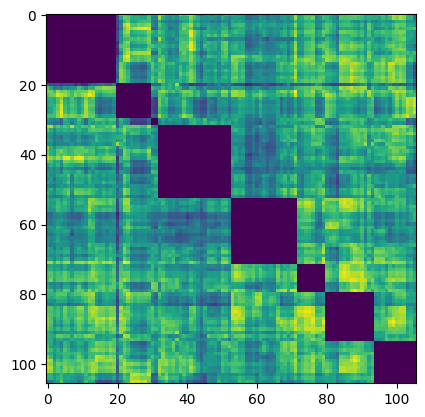

In [16]:
similarity_corrected = similarity
similarity_corrected[:20,:20] = 0
similarity_corrected[20:30,20:30] = 0
similarity_corrected[30:32,30:32] = 0
similarity_corrected[32:53,32:53] = 0
similarity_corrected[53:72,53:72] = 0
similarity_corrected[72:80,72:80] = 0
similarity_corrected[80:94,80:94] = 0
similarity_corrected[94:,94:] = 0

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(similarity_corrected)

## Get Badger Identity 

In [17]:
import numpy as np
from wildlife_tools.inference import KnnClassifier

classifier = KnnClassifier(k=1, database_labels=labels)
predictions = classifier(similarity_corrected)
accuracy = np.mean(df["identity"].to_numpy() == predictions)

In [18]:
accuracy_1 = np.mean(predictions[labels == 1] == 1)
accuracy_1

np.float64(0.5660377358490566)

In [19]:
accuracy_2 = np.mean(predictions[labels == 2] == 2)
accuracy_2

np.float64(0.8780487804878049)

In [20]:
accuracy_3 = np.mean(predictions[labels == 3] == 3)
accuracy_3

np.float64(0.0)

## Plot All Images with Ground Truth and Predictions

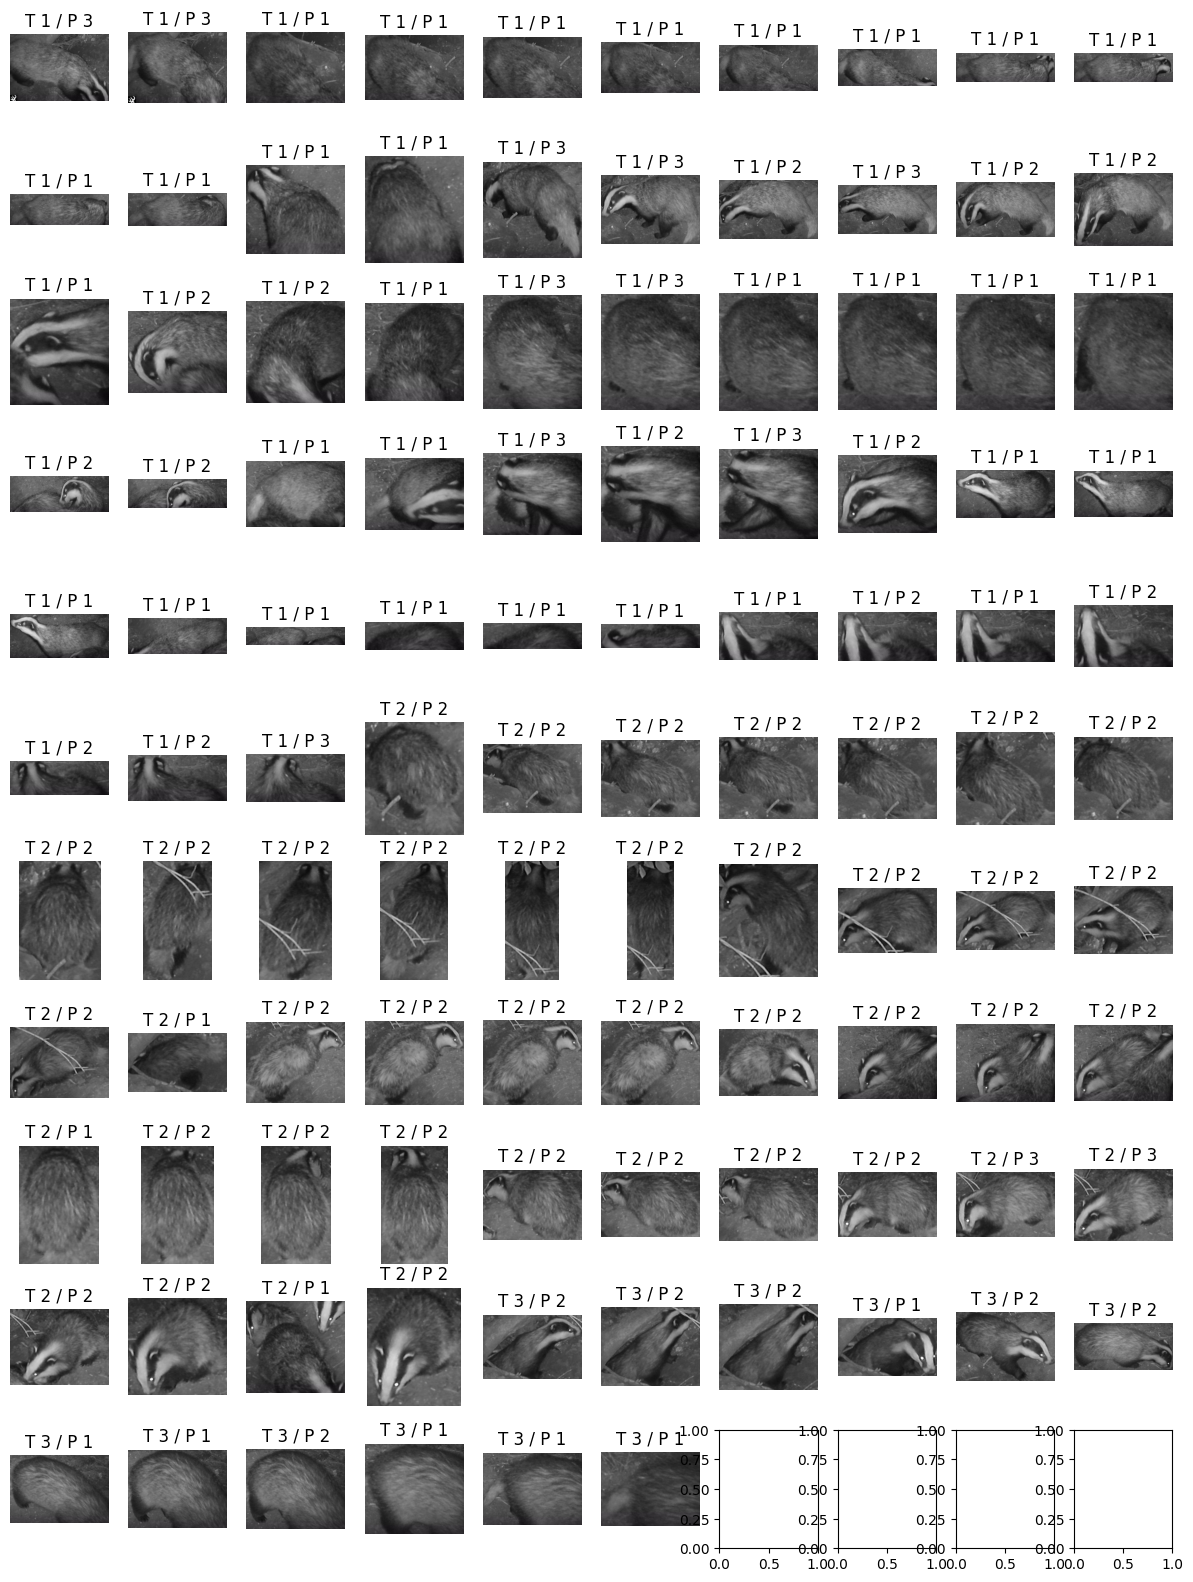

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to plot images with titles
def plot_images_with_titles(df, image_column, title_column, pred):
    fig, axes = plt.subplots(11, 10, figsize=(15, 5 * 4), )
    
    for i in range(11*10):
        if i <= 105:
            img = mpimg.imread("query_reference_data\\" + df[image_column].iloc[i])
            ax = axes[i // 10, i % 10]
            ax.imshow(img)
            ax.set_title("T "+str(df[title_column].iloc[i]) + " / P " + str(pred[i]))
            ax.axis('off')
    
    plt.show()

# Call the function
plot_images_with_titles(df, 'path', 'identity', predictions)
